<a href="https://colab.research.google.com/github/rizkiar00/HMMPosTaggingIndonesia/blob/main/PosTagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:


!wget  https://github.com/kmkurn/id-pos-tagging/blob/master/data/dataset.tar.gz?raw=true
# open file
import tarfile

file = tarfile.open('dataset.tar.gz?raw=true')
  
# extracting file
file.extractall('dataset')
  
file.close()

--2021-04-03 03:37:34--  https://github.com/kmkurn/id-pos-tagging/blob/master/data/dataset.tar.gz?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/kmkurn/id-pos-tagging/raw/master/data/dataset.tar.gz [following]
--2021-04-03 03:37:34--  https://github.com/kmkurn/id-pos-tagging/raw/master/data/dataset.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kmkurn/id-pos-tagging/master/data/dataset.tar.gz [following]
--2021-04-03 03:37:34--  https://raw.githubusercontent.com/kmkurn/id-pos-tagging/master/data/dataset.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connecte

In [7]:
# Importing libraries
import nltk
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import pprint, time
 
#download the treebank corpus from nltk
nltk.download('treebank')
 
#download the universal tagset from nltk
nltk.download('universal_tagset')
 
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
 
#print the first two sentences along with tags
print(nltk_data[:2])

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')]]


In [8]:
import csv
with open('/content/dataset/train.01.tsv', newline='') as f:
    reader = csv.reader(f,delimiter='\t',quoting=csv.QUOTE_NONE)
    train_set = list(reader)

print(train_set[0:40])
print(len(train_set))

[['Pemerintah', 'NN'], ['bahkan', 'RB'], ['telah', 'MD'], ['mencanangkan', 'VB'], ['dana', 'NN'], ['untuk', 'SC'], ['memicu', 'VB'], ['sektor', 'NN'], ['usaha', 'NN'], ['kecil', 'JJ'], ['dan', 'CC'], ['menengah', 'JJ'], ['UKM', 'NN'], ['tumbuh', 'VB'], ['lebih', 'RB'], ['baik', 'JJ'], [',', 'Z'], ['karena', 'SC'], ['sektor', 'NN'], ['ini', 'PR'], ['cukup', 'RB'], ['kuat', 'JJ'], ['dalam', 'IN'], ['krisis', 'JJ'], ['keuangan', 'NN'], ['pada', 'IN'], ['tahun', 'NN'], ['1997', 'CD'], ['lalu', 'CC'], [',', 'Z'], ['kata', 'VB'], ['-nya', 'PRP'], ['.', 'Z'], [], ['Gubernur', 'NNP'], ['Bank', 'NNP'], ['Indonesia', 'NNP'], ['Burhanudin', 'NNP'], ['Abdullah', 'NNP'], ['optimistis', 'JJ']]
191567


In [9]:
with open('/content/dataset/test.01.tsv', newline='') as f:
    reader = csv.reader(f,delimiter='\t')
    test_set = list(reader)
print(test_set[0:30])
print(len(test_set))

[['Pemerintah', 'NNP'], ['AS', 'NNP'], [',', 'Z'], ['pimpinan', 'NN'], ['Presiden', 'NNP'], ['George', 'NNP'], ['W.', 'NNP'], ['Bush', 'NNP'], [',', 'Z'], ['dalam', 'IN'], ['beberapa', 'CD'], ['pekan', 'NN'], ['belakangan', 'NN'], ['telah', 'MD'], ['meningkatkan', 'VB'], ['pendirian', 'NN'], ['-nya', 'PRP'], ['terhadap', 'IN'], ['Iran', 'NNP'], [',', 'Z'], ['yang', 'SC'], ['telah', 'MD'], ['dituduh', 'VB'], ['Barat', 'NNP'], ['secara', 'IN'], ['diam-diam', 'RB'], ['sedang', 'MD'], ['berusaha', 'VB'], ['membuat', 'VB'], ['bom atom', 'NN']]
53481


In [10]:
def transform(w, lower=True, replace_digits=True):
    
    if lower:
        w = w.lower()
    if replace_digits:
        w = re.sub(r'\d+', '0', w)
    return w

In [11]:
# create list of train and test tagged words
# train_tagged_words = [ tup for sent in train_set for tup in sent ]
# test_tagged_words = [ tup for sent in test_set for tup in sent ]
# print(len(train_tagged_words))
# print(len(test_tagged_words))
import regex as re

def Remove(tuples):
    tuples = [t for t in tuples if t]
    return tuples

train_set = Remove(train_set)
test_set = Remove(test_set)

train_tagged_words = []
for alist in train_set:
    alist[0] = transform(alist[0])
    
    train_tagged_words.append(tuple(alist))

test_tagged_words = []
for alist in test_set:
    alist[0] = transform(alist[0])
    test_tagged_words.append(tuple(alist))
print(train_tagged_words[:5])
print(test_tagged_words[:5])

[('pemerintah', 'NN'), ('bahkan', 'RB'), ('telah', 'MD'), ('mencanangkan', 'VB'), ('dana', 'NN')]
[('pemerintah', 'NNP'), ('as', 'NNP'), (',', 'Z'), ('pimpinan', 'NN'), ('presiden', 'NNP')]


In [12]:

tags = {tag for word,tag in train_tagged_words}
print(len(tags))
print(tags)
 
# check total words in vocabulary
vocab = {word for word,tag in train_tagged_words}
print(len(vocab))


23
{'OD', 'NND', 'VB', 'X', 'NNP', 'CC', 'FW', 'SYM', 'DT', 'RB', 'WH', 'PRP', 'SC', 'JJ', 'Z', 'CD', 'RP', 'NEG', 'MD', 'IN', 'NN', 'UH', 'PR'}
11680


In [13]:
def transform(w, lower=True, replace_digits=True):
    if lower:
        w = w.lower()
    if replace_digits:
        w = re.sub(r'\d+', '0', w)
    return w

In [14]:
# compute Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)#total number of times the passed tag occurred in train_bag
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
#now calculate the total number of times the passed word occurred as the passed tag.
    count_w_given_tag = len(w_given_tag_list)
 
     
    return (count_w_given_tag, count_tag)

# compute  Transition Probability
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [35]:


tags_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))
display(tags_df)

,OD,NND,VB,X,NNP,CC,FW,SYM,DT,RB,WH,PRP,SC,JJ,Z,CD,RP,NEG,MD,IN,NN,UH,PR
OD,0.003697,0.033272,0.072089,0.000000,0.055453,0.022181,0.016636,0.003697,0.000000,0.005545,0.000000,0.022181,0.064695,0.014787,0.170055,0.245841,0.000000,0.001848,0.014787,0.109057,0.116451,0.000000,0.027726
NND,0.000979,0.036239,0.038198,0.000000,0.009794,0.021548,0.004897,0.000000,0.000000,0.007835,0.000000,0.009794,0.016650,0.005877,0.112635,0.007835,0.004897,0.000000,0.007835,0.087169,0.622919,0.000000,0.004897
VB,0.000219,0.007196,0.062308,0.001667,0.061211,0.011891,0.005836,0.019526,0.002720,0.016191,0.002984,0.061825,0.051075,0.019614,0.071523,0.072269,0.000527,0.003423,0.010575,0.158754,0.353225,0.000000,0.005441
X,0.013605,0.000000,0.081633,0.006803,0.102041,0.064626,0.000000,0.000000,0.003401,0.017007,0.000000,0.037415,0.105442,0.047619,0.180272,0.023810,0.000000,0.003401,0.023810,0.105442,0.163265,0.000000,0.020408
NNP,0.000966,0.000040,0.085530,0.000443,0.418072,0.034977,0.005796,0.001046,0.000040,0.011833,0.000000,0.001650,0.037432,0.006802,0.228939,0.028255,0.000241,0.004226,0.019400,0.078084,0.024673,0.000040,0.011511
CC,0.000564,0.005261,0.154453,0.003382,0.112176,0.006389,0.009771,0.007892,0.003006,0.033822,0.001503,0.018414,0.023675,0.041150,0.042841,0.067268,0.001691,0.016535,0.021233,0.044908,0.372228,0.000000,0.011838
FW,0.000600,0.000600,0.048619,0.010804,0.060624,0.036615,0.355342,0.006603,0.000000,0.011405,0.000000,0.010204,0.054022,0.033013,0.159064,0.019808,0.000600,0.004802,0.011405,0.078631,0.071429,0.000000,0.025810
SYM,0.000000,0.000000,0.009560,0.000000,0.002549,0.004461,0.001275,0.008923,0.000637,0.000000,0.000000,0.000637,0.002549,0.005736,0.029318,0.905672,0.000000,0.000000,0.000000,0.018483,0.010198,0.000000,0.000000
DT,0.000000,0.000000,0.018051,0.000000,0.010830,0.000000,0.018051,0.000000,0.000000,0.000000,0.000000,0.003610,0.000000,0.007220,0.000000,0.000000,0.000000,0.000000,0.003610,0.000000,0.938628,0.000000,0.000000
RB,0.000000,0.000578,0.375108,0.001155,0.007508,0.004909,0.005198,0.007219,0.000289,0.022235,0.000578,0.019347,0.023968,0.213976,0.052267,0.046491,0.002599,0.013283,0.066416,0.076523,0.056021,0.000000,0.004332


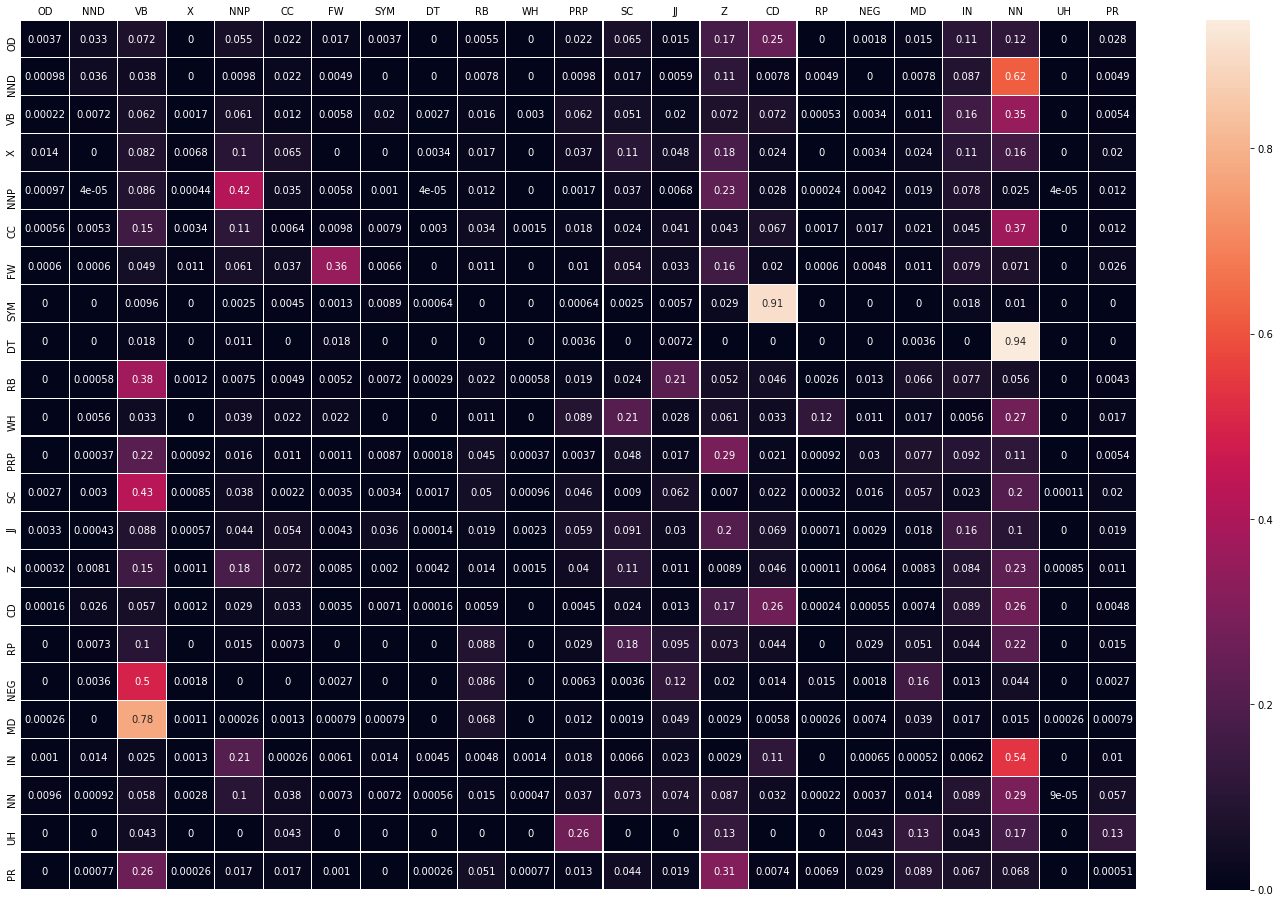

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (25,16))

ax = sns.heatmap(tags_df, linewidths=.1,annot=True)
ax.xaxis.tick_top()
ax.tick_params(length=0)

In [40]:
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
     
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['Z', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                 
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
             
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [45]:

# list of 10 sents on which we test the model
test_run = test_set[0:10]
 
# list of tagged words
test_run_base = [tuple(sent) for sent in test_run]
 
# list of untagged words
test_tagged_words = [sent[0] for sent in test_run]

#Here We will only test 10 sentences to check the accuracy
#as testing the whole training set takes huge amount of time
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
 
print("Time taken in seconds For The First 10th Word: ", difference)
 
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
 
accuracy = len(check)/len(tagged_seq)
print('Viterbi Algorithm Accuracy For The First 10th Word: ',accuracy*100)


Time taken in seconds For The First 10th Word:  8.974841356277466
Viterbi Algorithm Accuracy For The First 10th Word:  90.0


In [47]:
#Code to test all the test sentences
#(takes alot of time to run s0 we wont run it here)
# tagging the test sentences()
from pathlib import Path
import csv

test_tagged_words = [tuple(sent) for sent in test_set]
test_untagged_words = [sent[0] for sent in test_set]
#test_untagged_words

interval = 2000
filename = '/content/drive/MyDrive/output.csv'
if Path(filename).is_file():
    with open(filename, newline='') as f:
        reader = csv.reader(f)
        listtagged_seq = list(reader)
    prevtagged_seq = []
    for i in listtagged_seq:
        prevtagged_seq.append(tuple(i))
    startidx = len(prevtagged_seq)
else:
    startidx = 0
    prevtagged_seq = []

endinterval = startidx + interval #(titik pada kalimat terakhir)
if endinterval > len(test_untagged_words):
    endinterval = len(test_untagged_words)-1


for i in range(endinterval,len(test_untagged_words)):
    if test_untagged_words[i] == '.':
        break
endinterval = i+1

if len(prevtagged_seq) < len(test_tagged_words):


    start = time.time()
    current = start

    tagged_seq = Viterbi(test_untagged_words[startidx:endinterval])
    end = time.time()
    difference = end-start
    wordcount = endinterval - startidx
    print("Finish at index: ", endinterval)
    print("Number of Word Prcessed: ", wordcount)
    print("Time taken in seconds: ", difference)


    # accuracy
    check = [i for i, j in zip(tagged_seq, test_tagged_words[startidx:endinterval]) if i == j] 
    
    accuracy = len(check)/len(tagged_seq)
    print('Viterbi Algorithm Accuracy: ',accuracy*100)



    prevtagged_seq.extend(tagged_seq)
    listouput = []
    for tuples in prevtagged_seq:
        listouput.append(list(tuples))
    with open(filename, "w") as f:
        writer = csv.writer(f)
        writer.writerows(listouput)
if len(prevtagged_seq) >= len(test_tagged_words):
    print("Part Of Speech Tagging has Been Finished")

Part Of Speech Tagging has Been Finished


In [48]:
with open(filename, newline='') as f:
    reader = csv.reader(f)
    listtagged_seq = list(reader)
    prevtagged_seq = []
for i in listtagged_seq:
    prevtagged_seq.append(tuple(i))

check = [i for i, j in zip(prevtagged_seq, test_tagged_words[0:len(prevtagged_seq)]) if i == j] 
 
accuracy = len(check)/len(test_tagged_words[0:len(prevtagged_seq)])
print('Viterbi Algorithm Accuracy: ',accuracy*100)

Viterbi Algorithm Accuracy:  93.69985429820301


In [66]:
import nltk

print('Masukkan Kalimat yang akan di Post Tagging: ')
sentence = input()
sentence = nltk.word_tokenize(sentence)
sentence = list(map(transform, sentence))
taggedsentence = Viterbi(sentence)
print(taggedsentence)


Masukkan Kalimat yang akan di Post Tagging: 
Aku makan ayam goreng kfc. AS mempersiapkan cuaca musim dingin.
[('aku', 'VB'), ('makan', 'VB'), ('ayam', 'OD'), ('goreng', 'OD'), ('kfc', 'OD'), ('.', 'Z'), ('as', 'NNP'), ('mempersiapkan', 'VB'), ('cuaca', 'NN'), ('musim', 'NN'), ('dingin', 'NNP'), ('.', 'Z')]
